In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf
import cv2

from keras.preprocessing.image import ImageDataGenerator

import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [ ]:
# access the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

In [ ]:
# take the image dir and number of image, then plot the image using matplotlib
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

In [ ]:
# set the path for 4 types image folder
path_normal = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/'
path_stone = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'
path_cyst = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'
path_tumor = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'

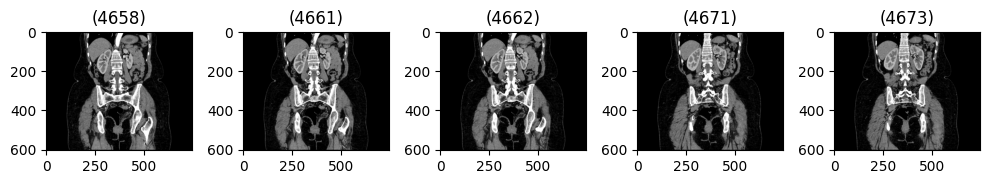

In [ ]:
# show the normal images
plot_imgs(path_normal, 5)

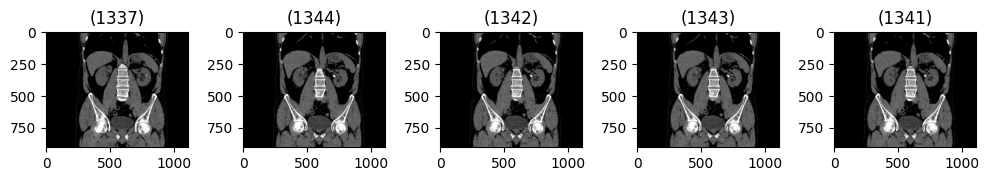

In [ ]:
# show the stone images
plot_imgs(path_stone, 5)

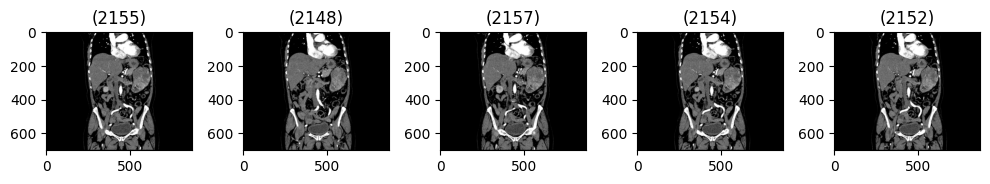

In [ ]:
# show the tumor images
plot_imgs(path_tumor, 5)

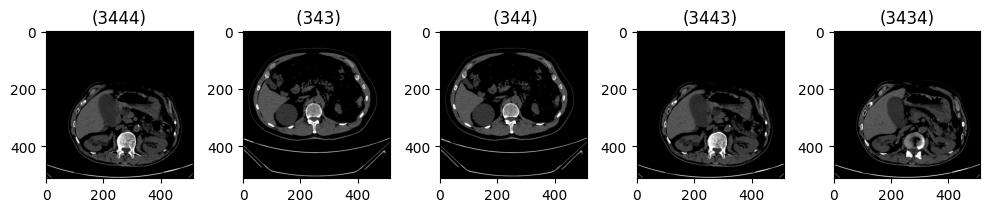

In [ ]:
# show the cyst images
plot_imgs(path_cyst, 5)

In [ ]:
# split the dataset folder to train/val/test set
splitfolders.ratio(
    "/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.8,0.1, 0.1)
)

Copying files: 12473 files [05:00, 41.58 files/s] 


In [ ]:
# rescale the images to reduce the more numeric calculation 
# multiply by 1/255 bring the image pixel to 0-1 range
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)


**flow_from_directory()**
* The directory must be set to the path where your ‘n’ classes of folders are present.   
*   The target_size is the size of your input images, every image will be resized to this size.
* color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
* batch_size: No. of images to be yielded from the generator per batch.
* class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
* shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
* seed: Random seed for applying random image augmentation and shuffling the order of the image.



In [ ]:
train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 9977 images belonging to 4 classes.
Found 1251 images belonging to 4 classes.
Found 1245 images belonging to 4 classes.


In [ ]:
# train dataset image size. we provide 200x200 grayscale image so channel is 1
train_dataset.image_shape

(200, 200, 1)

In [ ]:
# train dataset class indices
train_dataset.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

[Conv2D args
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```



In [ ]:
# create a Sequential model of 12 layers
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # convert 2d array to 1d array
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
 
])

In [ ]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
# fit the model with 40 epochs and 5 steps per epoch
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 5,
                      epochs = 40)

Epoch 1/40
5/5 [==============================] - 31s 4s/step - loss: 1.5423 - accuracy: 0.3080 - precision: 0.3300 - recall: 0.0660 - val_loss: 1.3207 - val_accuracy: 0.3598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 15s 3s/step - loss: 1.2866 - accuracy: 0.4000 - precision: 0.7241 - recall: 0.0420 - val_loss: 1.2705 - val_accuracy: 0.4080 - val_precision: 0.5369 - val_recall: 0.3920
Epoch 3/40
5/5 [==============================] - 14s 3s/step - loss: 1.2957 - accuracy: 0.3740 - precision: 0.5325 - recall: 0.0820 - val_loss: 1.2929 - val_accuracy: 0.4080 - val_precision: 0.4334 - val_recall: 0.4080
Epoch 4/40
5/5 [==============================] - 14s 3s/step - loss: 1.2321 - accuracy: 0.4000 - precision: 0.5638 - recall: 0.1680 - val_loss: 1.2147 - val_accuracy: 0.4080 - val_precision: 0.5547 - val_recall: 0.3912
Epoch 5/40
5/5 [==============================] - 14s 3s/step - loss: 1.2273 - accuracy: 0.4160 - precision: 0.6

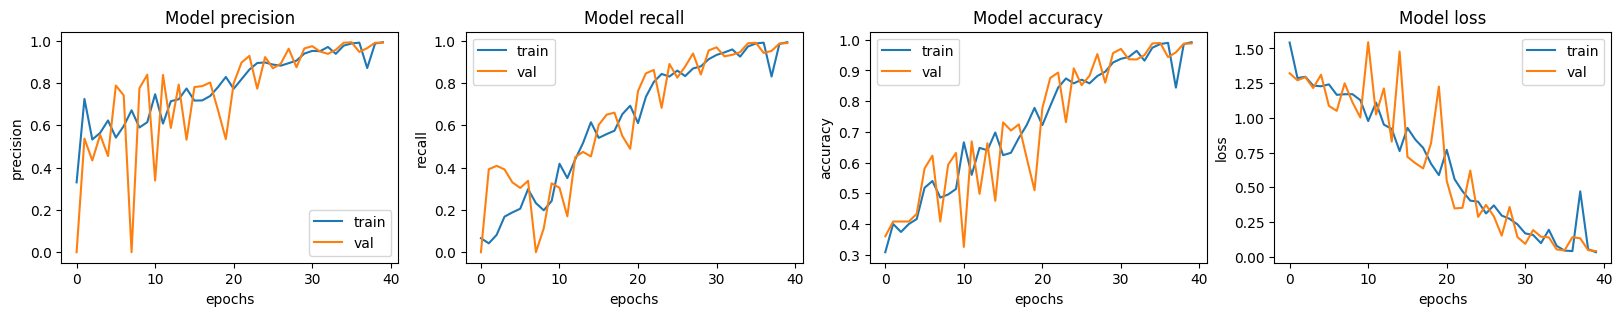

In [ ]:
# plot the fit model history precision, recall, accuracy, loss graph w.r.t train and validation set

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# test the model by using test_dataset
predictions = model.predict(test_dataset)

13/13 [==============================] - 12s 921ms/step


In [ ]:
# show the prediction array of 4 types of image class
predictions

array([[9.9999964e-01, 4.3250695e-10, 7.4474308e-08, 2.8997337e-07],
       [9.9272549e-01, 4.4371649e-05, 6.9360207e-03, 2.9405041e-04],
       [9.9655676e-01, 3.1162952e-05, 3.1398700e-03, 2.7222899e-04],
       ...,
       [1.8243192e-05, 8.8395730e-02, 6.3312800e-06, 9.1157973e-01],
       [3.3366578e-03, 2.8000134e-03, 1.4637451e-04, 9.9371690e-01],
       [1.6260536e-03, 2.0269793e-03, 1.7135667e-04, 9.9617553e-01]],
      dtype=float32)

In [ ]:
# convert the diseases dictioary to list
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [ ]:
# calculate the model accuracy and plot the confusion matrix of test dataset
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.9904076738609112
Precision: 0.9851680871212122
Recall: 0.9865053399218786
F1_score: 0.985810559399719


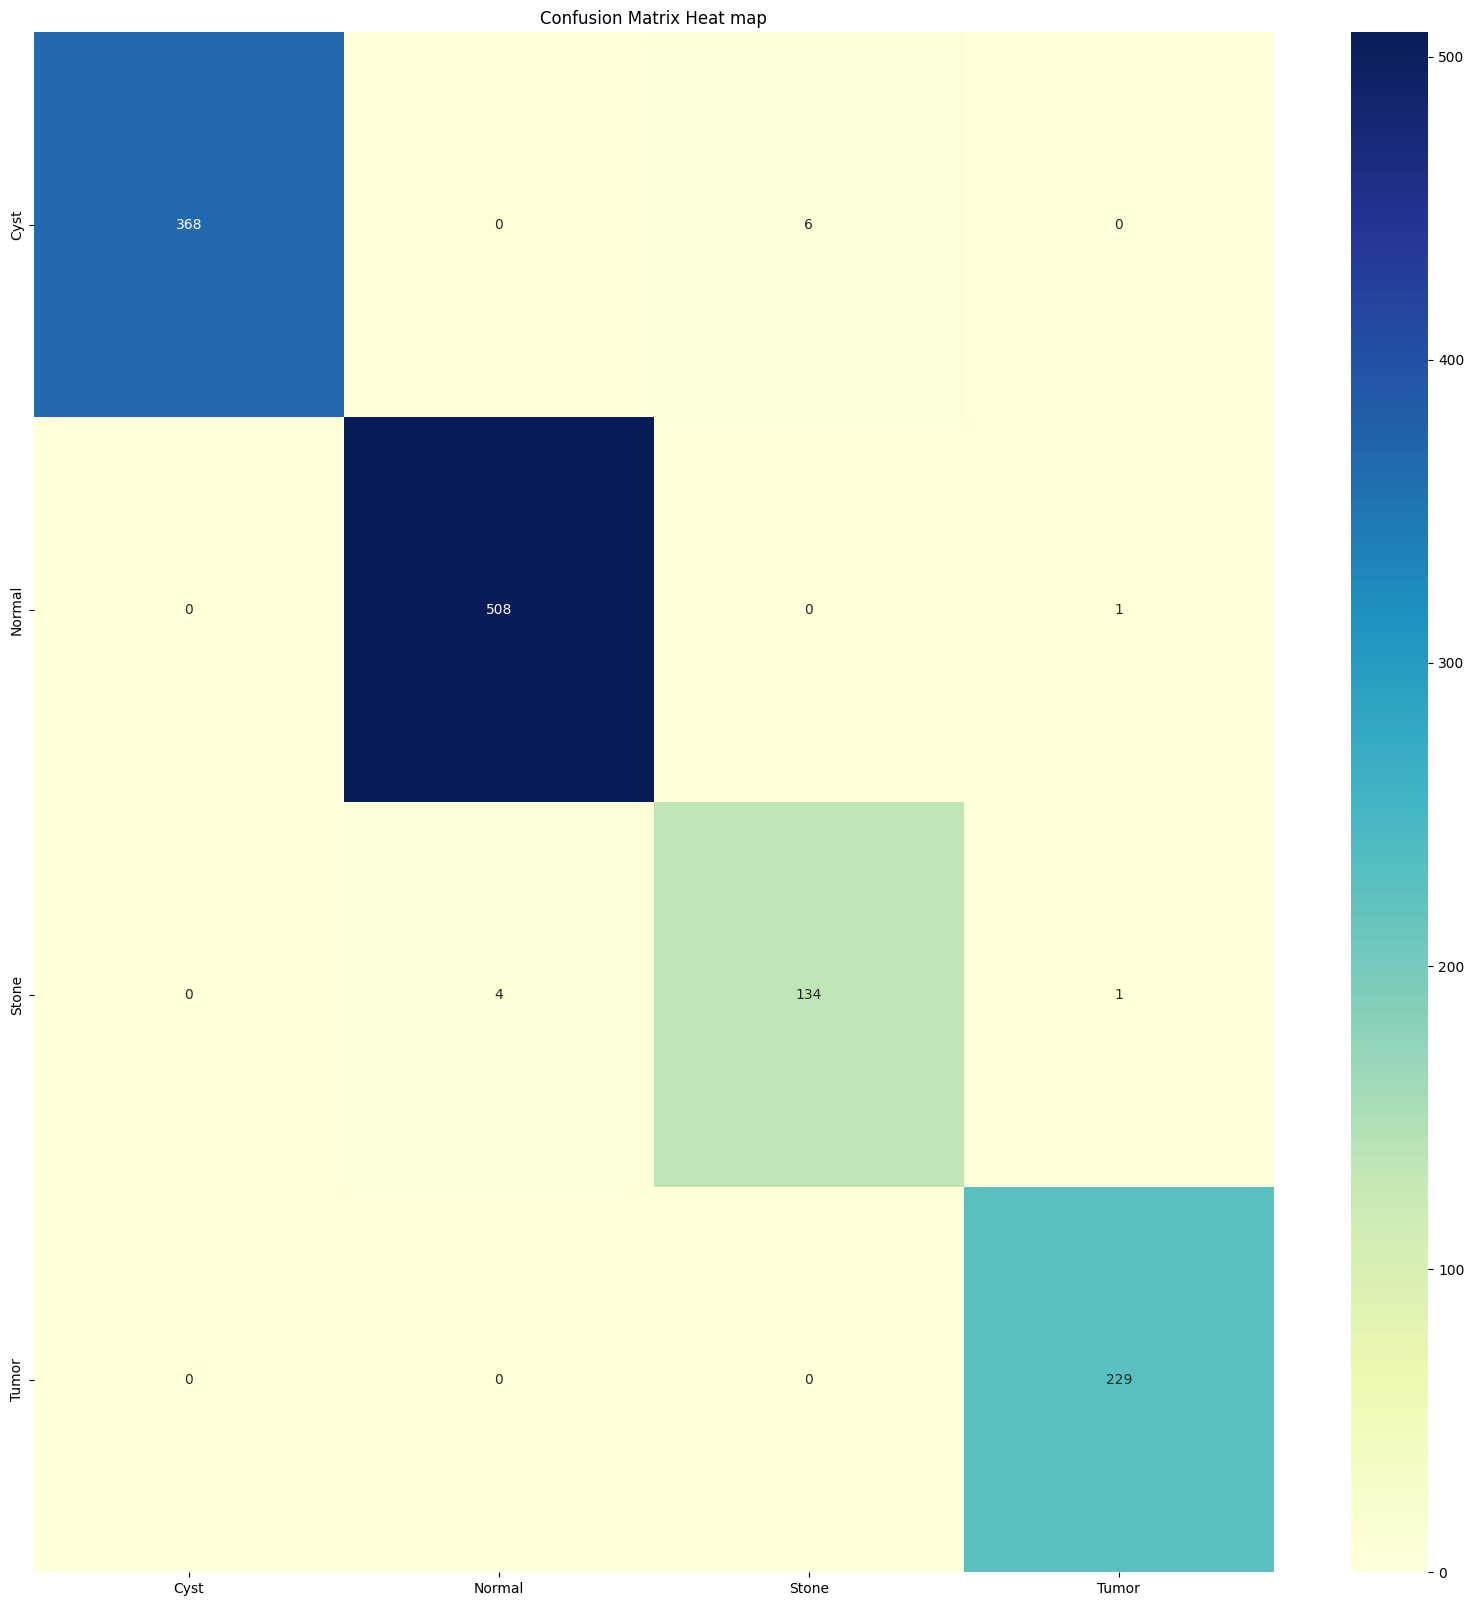

In [ ]:
evaluate(test_dataset.classes,predictions)

In [ ]:
from keras.models import load_model
model.save("/content/drive/MyDrive/kidneyStoneModel/final_model/final_model_CNN.h5")